In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../options-df-sigma.csv')
df = df.dropna(axis=0)
df = df.drop(columns=['date', 'exdate', 'impl_volatility', 'volume', 'open_interest'])
df.strike_price = df.strike_price / 1000
call_df = df[df.cp_flag == 'C'].drop(['cp_flag'], axis=1)
put_df = df[df.cp_flag == 'P'].drop(['cp_flag'], axis=1)

In [3]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(call_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                        call_df[['best_bid', 'best_offer']],
                                                                        test_size=0.01, random_state=42)
put_X_train, put_X_test, put_y_train, put_y_test = train_test_split(put_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                    put_df[['best_bid', 'best_offer']],
                                                                    test_size=0.01, random_state=42)

In [4]:
from keras.models import load_model
call = load_model('mlp2-call60.h5')
put = load_model('mlp2-put60.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
call_y_pred = call.predict(call_X_test)
put_y_pred = put.predict(put_X_test)

In [20]:
resid = call_y_test - call_y_pred
rel = resid / call_y_test

In [21]:
rel = rel.replace([np.inf, -np.inf], np.nan)
rel = rel.dropna()

(-5, 1)

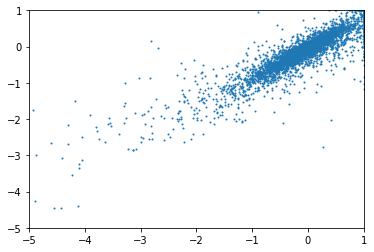

In [22]:
plt.scatter(rel.iloc[:,0], rel.iloc[:,1], s=1)
plt.xlim(-5, 1)
plt.ylim(-5, 1)

In [23]:
norms = np.linalg.norm(rel - np.zeros(2), axis=1)

(array([1.4817e+04, 7.4020e+03, 3.6830e+03, 2.2790e+03, 1.4380e+03,
        1.1190e+03, 9.5600e+02, 7.9500e+02, 6.7500e+02, 5.4200e+02,
        5.0600e+02, 4.4000e+02, 3.9600e+02, 3.5800e+02, 3.5400e+02,
        2.7800e+02, 2.8200e+02, 2.5100e+02, 2.2400e+02, 2.3100e+02,
        1.9300e+02, 1.9600e+02, 1.9000e+02, 1.7600e+02, 1.3000e+02,
        1.4100e+02, 1.2500e+02, 1.3100e+02, 1.1700e+02, 1.3900e+02,
        1.2600e+02, 1.1300e+02, 7.8000e+01, 9.0000e+01, 1.0100e+02,
        9.7000e+01, 8.9000e+01, 6.0000e+01, 7.0000e+01, 8.3000e+01,
        9.2000e+01, 5.2000e+01, 7.2000e+01, 5.8000e+01, 7.5000e+01,
        6.9000e+01, 5.7000e+01, 5.1000e+01, 4.6000e+01, 4.9000e+01,
        5.4000e+01, 4.9000e+01, 3.4000e+01, 3.7000e+01, 5.2000e+01,
        4.7000e+01, 3.5000e+01, 2.8000e+01, 3.6000e+01, 2.3000e+01,
        3.1000e+01, 4.1000e+01, 3.8000e+01, 4.5000e+01, 3.0000e+01,
        2.5000e+01, 3.3000e+01, 3.0000e+01, 1.7000e+01, 2.8000e+01,
        2.2000e+01, 1.9000e+01, 3.0000e+01, 2.50

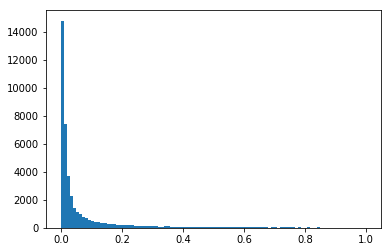

In [24]:
plt.hist(norms[norms < 1], bins=100)

In [25]:
sum(norms < 0.05) / norms.shape[0]

0.6228426075805672

Text(0, 0.5, 'ask error %')

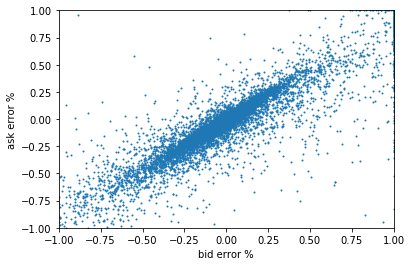

In [73]:
plt.scatter(rel.iloc[:,0], rel.iloc[:,1], s=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('bid error %')
plt.ylabel('ask error %')

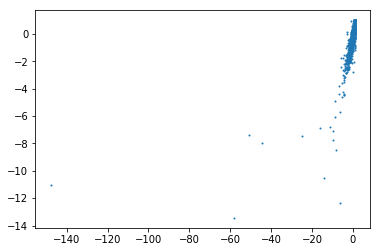

In [50]:
plt.scatter(rel.iloc[:,0], rel.iloc[:,1], s=1)

Text(0, 0.5, 'ask error')

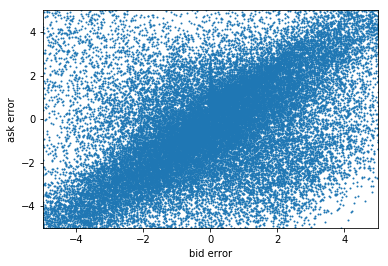

In [76]:
plt.scatter(resid.iloc[:,0], resid.iloc[:,1], s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel('bid error')
plt.ylabel('ask error')

In [6]:
pred_mid = np.mean(call_y_pred, axis=1)
test_mid = np.mean(call_y_test, axis=1)

In [78]:
np.mean(np.square(test_mid - pred_mid))

15.212845939922776

In [7]:
pred_spread = np.diff(call_y_pred, axis=1)
test_spread = np.diff(call_y_test, axis=1)

In [80]:
np.mean(np.square(test_spread - pred_spread))

7.571418826319726

(-5, 5)

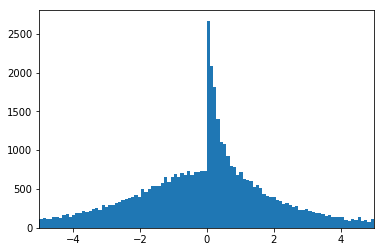

In [82]:
plt.hist(test_mid - pred_mid, bins=1000)
plt.xlim(-5, 5)

In [47]:
def error_metrics(actual, predicted):
    diff = actual - predicted
    mse = np.mean(np.square(diff))
    rel = diff / actual
    bias = 100 * np.median(rel)
    aape = 100 * np.mean(np.abs(rel))
    mape = 100 * np.median(np.abs(rel))
    pe5 = 100 * sum(np.abs(rel) < 0.05) / rel.shape[0]
    pe10 = 100 * sum(np.abs(rel) < 0.10) / rel.shape[0]
    pe20 = 100 * sum(np.abs(rel) < 0.20) / rel.shape[0]
    return [mse, bias, aape, mape, pe5, pe10, pe20]

In [48]:
error_metrics(test_mid, pred_mid)

[15.212845939922776,
 0.0862092151646021,
 23.446783186789986,
 1.734957485213201,
 63.034020537743984,
 70.0968095947323,
 75.54087951712785]

In [49]:
error_metrics(test_spread, pred_spread)

[7.571418826319726,
 0.6092602148987317,
 74.8548114360292,
 49.99722800888386,
 array([5.82425335]),
 array([11.49760916]),
 array([22.85019989])]

(-1, 1)

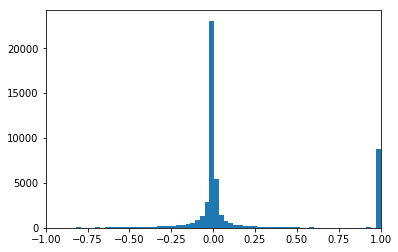

In [46]:
plt.hist((test_mid - pred_mid) / test_mid, bins=1000)
plt.xlim(-1, 1)

(-5, 5)

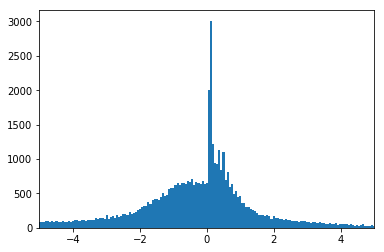

In [85]:
plt.hist(test_spread - pred_spread, bins=500)
plt.xlim(-5, 5)

In [14]:
temp = np.reshape((test_spread - pred_spread), test_mid.shape[0]) / test_mid

(-0.1, 0.1)

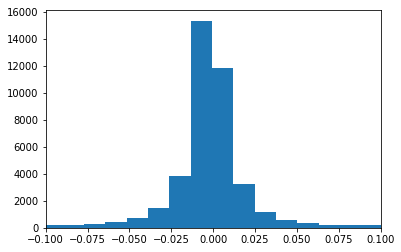

In [19]:
plt.hist(temp, bins=1000)
plt.xlim(-.1, .1)

In [26]:
inf_norm = np.linalg.norm(rel - np.zeros(2), ord=np.inf, axis=1)

In [27]:
sum(inf_norm < 0.05) / inf_norm.shape[0]

0.6489520486030819

In [29]:
sum(inf_norm < 0.01) / inf_norm.shape[0]

0.3444049696230739

In [38]:
def matrix(rel, q):
    def segregate(x, q):
        up = x > q
        low = x < -q
        mid = ~(up | low)
        return (up, mid, low)
    bid = rel.iloc[:,0]
    ask = rel.iloc[:,1]
    x = segregate(bid, q)
    y = segregate(ask, q)
    return np.array([[sum(x[i] & y[j]) for i in range(3)] for j in range(3)])

In [39]:
matrix(rel, 0.01) / rel.shape[0]

array([[0.26006433, 0.02690828, 0.01612395],
       [0.03746137, 0.34440497, 0.03399273],
       [0.01595577, 0.05146209, 0.21362652]])

In [40]:
matrix(rel, 0.05) / rel.shape[0]

array([[0.18463705, 0.00721058, 0.00132439],
       [0.01358027, 0.64895205, 0.00945994],
       [0.00428851, 0.01858353, 0.11196367]])

In [44]:
with np.printoptions(precision=3, suppress=True):
    print(matrix(rel, 0.1) / rel.shape[0])

[[0.156 0.004 0.001]
 [0.011 0.734 0.007]
 [0.002 0.012 0.074]]
